In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('..')

# Maths
import numpy as np
from scipy.spatial import ConvexHull

# Plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import Rectangle, Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, DivergingNorm, to_rgba

# Atoms
from ase.io import read
from ase.visualize.plot import plot_atoms

# ML
from kernels import sqeuclidean_distances

# Utilities
import h5py
import json
import project_utils as utils
import gzip
from copy import deepcopy

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# Functions

In [2]:
# Compute and save hull distances
def hull_distances(vprobprune, energies, projections, n_dim):
    gch_vertices = np.nonzero(vprobprune[-1])[0]
    
    vertices = np.zeros(projections.shape[0], dtype=int)
    vertices[gch_vertices] = 1
    
    energies_gch = energies[gch_vertices]
    projections_gch = projections[gch_vertices]
    
    ep = np.hstack((energies[:, np.newaxis], projections))
    ep_gch = np.hstack((energies_gch[:, np.newaxis], projections_gch))
    
    vertex_hull = ConvexHull(ep_gch[:, 0:n_dim])
    
    # Omit the simplices on the 'top' of the GCH
    vertex_hull_facets = np.delete(
        vertex_hull.equations,
        np.nonzero(vertex_hull.equations[:, 0] > 0.0),
        axis=0
    )
    
    hull_distance = -1.0 * (
        np.matmul(ep[:, 0:n_dim], vertex_hull_facets[:, 0:-1].T) 
        + vertex_hull_facets[:, -1]
    )
    
    hull_distance_energy = -1.0 * hull_distance / vertex_hull_facets[:, 0]
    
    hull_distance = np.amin(np.abs(hull_distance), axis=1)
    hull_distance_energy = np.amin(np.abs(hull_distance_energy), axis=1)
    
    return hull_distance, hull_distance_energy

# GCH

In [3]:
# TODO: analysis for all GCH's (different PCovR mixing)
# TODO: test set only for Deem, all IZA

In [4]:
cantons_iza = np.loadtxt('../../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
iza_delete = np.nonzero(cantons_iza == 4)[0][0]
deem_delete = np.loadtxt('../../Processed_Data/DEEM_330k/10kJmol_error.idxs', dtype=int)

In [5]:
iza_codes = np.loadtxt(f'../../Raw_Data/GULP/IZA_226/codes.txt', dtype=str)
iza_codes = np.delete(iza_codes, iza_delete)
cantons_iza = np.delete(cantons_iza, iza_delete)
n_iza = len(cantons_iza)

In [6]:
# Structure energies
deem_330k_energies = np.loadtxt('../../Raw_Data/GULP/DEEM_330k.bk/optimization_summary_fix.dat', usecols=2)
deem_330k_energies = np.delete(deem_330k_energies, deem_delete)

# TODO: change this when IZA re-optimized
iza_energies = np.loadtxt('../../Processed_Data/IZA_226/Data/structure_energies.dat')
iza_energies = np.delete(iza_energies, iza_delete)

energies = np.concatenate((iza_energies, deem_330k_energies))

In [7]:
# Structure volumes
deem_330k_volumes = np.loadtxt('../../Processed_Data/DEEM_330k/Data/structure_volumes.dat')
deem_330k_volumes = np.delete(deem_330k_energies, deem_delete)

iza_volumes = np.loadtxt('../../Processed_Data/IZA_226/Data/structure_volumes.dat')
iza_volumes = np.delete(iza_energies, iza_delete)

volumes = np.concatenate((iza_volumes, deem_330k_volumes))

In [8]:
# Decision functions
# TODO: use the 4-class DFs?
deem_330k_dfs = np.loadtxt('../../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')
deem_330k_dfs = np.delete(deem_330k_dfs, deem_delete)
iza_dfs = np.loadtxt('../../Processed_Data/IZA_226/Data/6.0/Linear_Models/LSVC-LPCovR/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')
#iza_dfs = np.delete(iza_dfs, iza_delete) # RWY already deleted!
dfs = np.concatenate((iza_dfs, deem_330k_dfs))

In [9]:
# Hull distances (TODO: change this so we just save all the useful properties from the GCH notebook)
gch_dir = '../../Processed_Data/Models/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/GCH'
vprobprune = np.loadtxt(f'{gch_dir}/rattled/vprobprune.dat')
T = np.loadtxt(f'{gch_dir}/T.dat')
ndim = 3

d, de = hull_distances(vprobprune, energies, T, ndim)

In [10]:
gch_vertices = np.nonzero(vprobprune[-1])[0]
iza_vertices = gch_vertices[gch_vertices < n_iza]
deem_vertices = gch_vertices[gch_vertices >= n_iza]

vertices = np.zeros(T.shape[0], dtype=int)
vertices[gch_vertices] = 1

## Check rattled structures

In [11]:
T = np.loadtxt(f'{gch_dir}/T.dat')
T_rattled = np.loadtxt(f'{gch_dir}/rattled/T.dat')
ref_idxs = np.loadtxt(f'{gch_dir}/rattled/refstruct.idx', dtype=int)

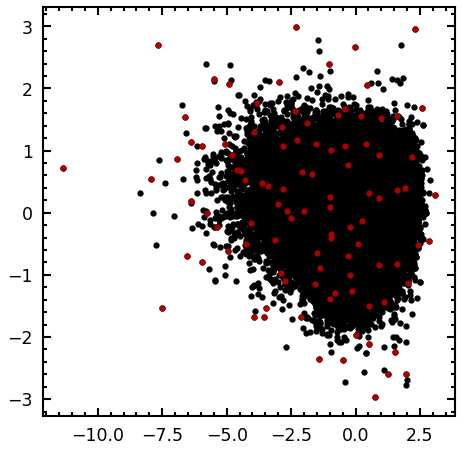

In [12]:
plt.scatter(T[:, 0], T[:, 1])
plt.scatter(T[ref_idxs, 0], T[ref_idxs, 1])
plt.show()

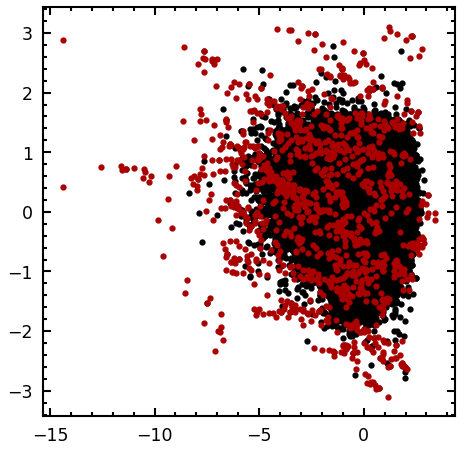

In [13]:
plt.scatter(T[:, 0], T[:, 1])
plt.scatter(T_rattled[:, 0], T_rattled[:, 1])
plt.show()

## Plot GCH

In [14]:
def histogram(X, Y, bins, return_edges=False):
    Z, X_edges, Y_edges = np.histogram2d(X, Y, bins=bins, density=True)
    dX = np.diff(X_edges)
    dY = np.diff(Y_edges)
    X_centers = X_edges[0:-1]
    Y_centers = Y_edges[0:-1]
    X_centers += dX / 2
    Y_centers += dY / 2
    X, Y = np.meshgrid(X_centers, Y_centers)
    
    if return_edges:
        return X, Y, Z.T, X_edges, Y_edges
    else:
        return X, Y, Z.T
    
def logbase(x, base):
    return np.log10(x) / np.log10(base)
    
def scale_points(data, min_value, max_value, inverted=False, log=False, base=10):
    normalized_data = (data - np.amin(data)) / (np.amax(data) - np.amin(data))
    if inverted:
        normalized_data = 1.0 - normalized_data
    
    if log:
        scaled_data = base ** (
            normalized_data * (
                logbase(max_value, base) - logbase(min_value, base)
            ) + logbase(min_value, base)
        )
    else:
        scaled_data =  normalized_data * (max_value - min_value) + min_value

    return scaled_data

In [15]:
frames = read(f'{gch_dir}/iza+deem.xyz', index=':')
frames_deem_vertices = [frames[idx] for idx in deem_vertices]
frames_iza_vertices = [frames[idx] for idx in iza_vertices]

In [16]:
base = 10
size_min = 1
size_max = 50
alpha_min = 0.01
alpha_max = 1.0
sizes = scale_points(de, size_min, size_max, inverted=True, log=True, base=base)
alphas = scale_points(de, alpha_min, alpha_max, inverted=True, log=True, base=base)

# vmin = np.amin(de)
# vmax = np.amax(de)

vmin = np.amin(dfs)
vmax = np.amax(dfs)
norm = DivergingNorm(vcenter=0.0, vmin=vmin, vmax=vmax)
color_map = ScalarMappable(norm=norm, cmap='RdBu')
colors = color_map.to_rgba(dfs, alpha=1.0)
colors[:, -1] = alphas

ecolors = np.tile(to_rgba(color_list[0]), (len(colors), 1))
ecolors[:, -1] = alphas

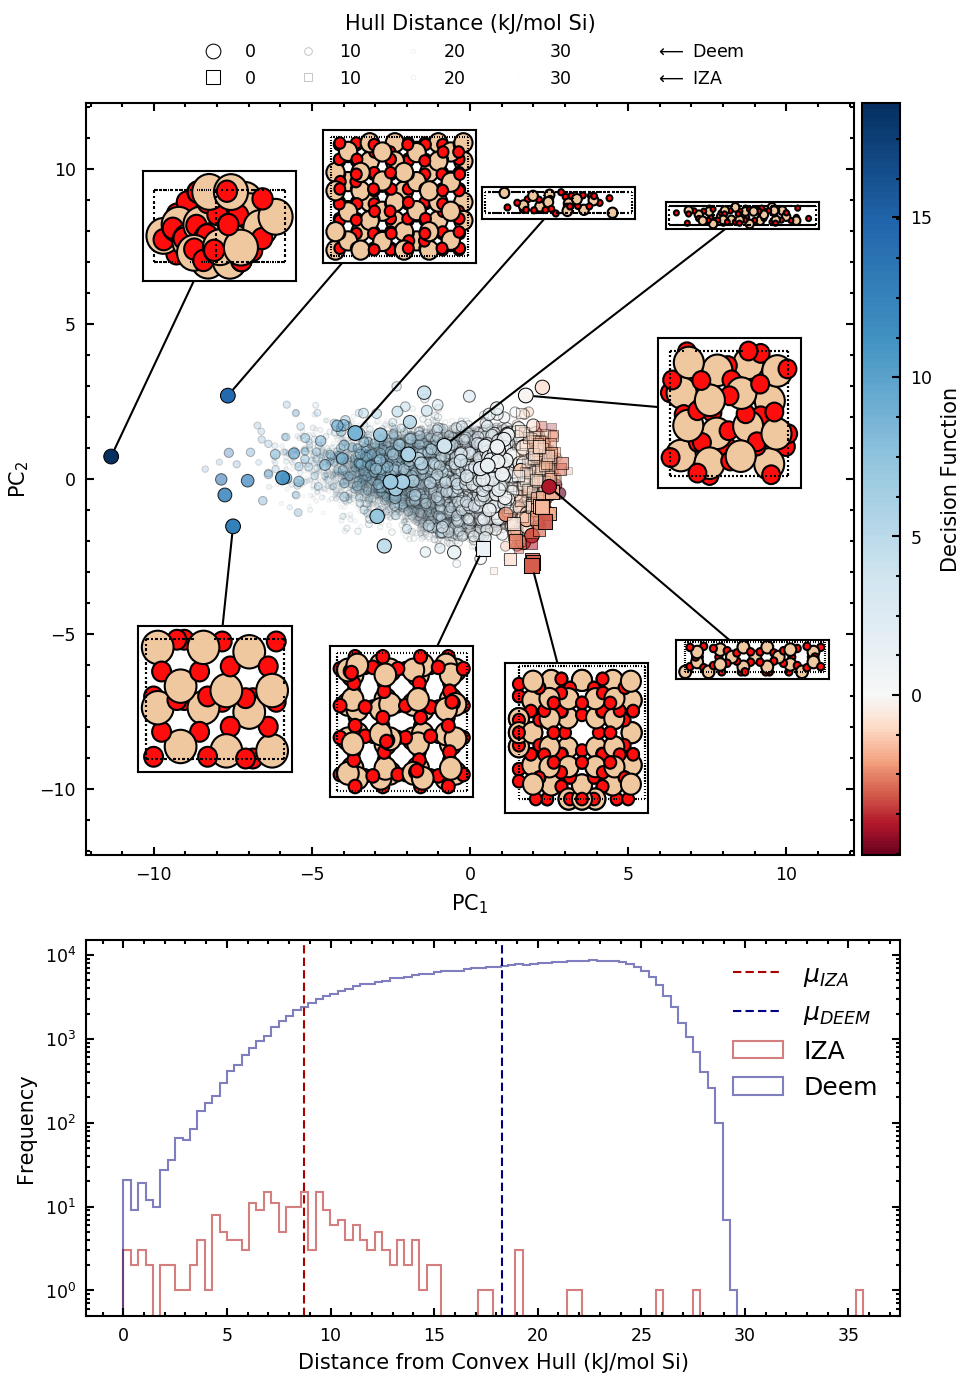

In [24]:
# Shapes for IZA (cantons), Deem
# Color for hull distance energy
# Highlights for vertices (make sure plotted on top)
# Contour plot on top?
# TODO: highlight the 4 archetypes: IZA-like IZA, IZA-like Deem, Deem-like IZA, Deem-like Deem
fig = plt.figure(figsize=(7.0, 10.5))
gs = fig.add_gridspec(
#     nrows=1, ncols=3,
    nrows=2, ncols=2,
#     width_ratios=(1.0, 0.05, 0.05),
    width_ratios=(1.0, 0.05), height_ratios=(1.0, 0.5),
    wspace=0.02, hspace=0.15
)

# GCH
axs = fig.add_subplot(gs[0, 0])
axs_hull = fig.add_subplot(gs[1, :])
caxs = fig.add_subplot(gs[0, -1])
# caxs_deem = fig.add_subplot(gs[0, -2])
# caxs_iza = fig.add_subplot(gs[0, -1])

T_iza = np.delete(T[0:n_iza], iza_vertices, axis=0)
de_iza = np.delete(de[0:n_iza], iza_vertices)
df_iza = np.delete(dfs[0:n_iza], iza_vertices)
s_iza = np.delete(sizes[0:n_iza], iza_vertices)
colors_iza = np.delete(colors[0:n_iza], iza_vertices, axis=0)
ecolors_iza = np.delete(ecolors[0:n_iza], iza_vertices, axis=0)
po_iza = np.flip(np.argsort(de_iza))

T_deem = np.delete(T[n_iza:], deem_vertices - n_iza, axis=0)
de_deem = np.delete(de[n_iza:], deem_vertices - n_iza)
df_deem = np.delete(dfs[n_iza:], deem_vertices - n_iza)
s_deem = np.delete(sizes[n_iza:], deem_vertices - n_iza)
colors_deem = np.delete(colors[n_iza:], deem_vertices - n_iza, axis=0)
ecolors_deem = np.delete(ecolors[n_iza:], deem_vertices - n_iza, axis=0)
po_deem = np.flip(np.argsort(de_deem))

T_iza_vertices = T[iza_vertices]
de_iza_vertices = de[iza_vertices]
df_iza_vertices = dfs[iza_vertices]
s_iza_vertices = sizes[iza_vertices]
colors_iza_vertices = colors[iza_vertices]
ecolors_iza_vertices = ecolors[iza_vertices]

T_deem_vertices = T[deem_vertices]
de_deem_vertices = de[deem_vertices]
df_deem_vertices = dfs[deem_vertices]
s_deem_vertices = sizes[deem_vertices]
colors_deem_vertices = colors[deem_vertices]
ecolors_deem_vertices = ecolors[deem_vertices]

# Deem
deem_pts = axs.scatter(
    T_deem[po_deem, 0], T_deem[po_deem, 1],
    #c=df_deem[po_deem], cmap='RdBu', norm=norm, #vmin=vmin, vmax=vmax,
    c=colors_deem[po_deem],
    #marker='o', edgecolor=color_list[0], linewidth=0.5, s=s_deem[po_deem]
    marker='o', edgecolor=ecolors_deem[po_deem], linewidth=0.5, s=s_deem[po_deem],
    rasterized=True
)
# IZA
iza_pts = axs.scatter(
    T_iza[po_iza, 0], T_iza[po_iza, 1],
    #c=df_iza[po_iza], cmap='RdBu', norm=norm, #vmin=vmin, vmax=vmax,
    c=colors_iza[po_iza],
    #marker='s', edgecolor=color_list[0], linewidth=0.5, s=s_iza[po_iza]
    marker='s', edgecolor=ecolors_iza[po_iza], linewidth=0.5, s=s_iza[po_iza],
    rasterized=True
)

# # Contour
# n_bins = 51
# levels = np.logspace(-4, 0, 6)

# X, Y, Z = histogram(T[:, 0], T[:, 1], n_bins)
# axs.contour(X, Y, Z, levels=levels, colors=color_list[0])

# Deem vertices
axs.scatter(
    T_deem_vertices[:, 0], T_deem_vertices[:, 1],
    #c=df_deem_vertices, cmap='RdBu', norm=norm, #vmin=vmin, vmax=vmax,
    c=colors_deem_vertices,
    #marker='o', edgecolor=color_list[0], linewidth=0.5, s=s_deem_vertices,
    marker='o', edgecolor=ecolors_deem_vertices, linewidth=0.5, s=s_deem_vertices,
    zorder=3,
    rasterized=True
)

# IZA vertices
axs.scatter(
    T_iza_vertices[:, 0], T_iza_vertices[:, 1],
    #c=df_iza_vertices, cmap='RdBu', norm=norm, #vmin=vmin, vmax=vmax,
    c=colors_iza_vertices,
    #marker='s', edgecolor=color_list[0], linewidth=0.5, s=s_iza_vertices,
    marker='s', edgecolor=ecolors_iza_vertices, linewidth=0.5, s=s_iza_vertices,
    zorder=3,
    rasterized=True
)

cb = fig.colorbar(color_map, cax=caxs, label='Decision Function')

# cb_deem = fig.colorbar(deem_pts, cax=caxs_deem)
# caxs_deem.tick_params(which='both', axis='y', labelright=False)
# caxs_deem.text(
#     0.5, 0.5,
#     'Deem',
#     horizontalalignment='center', verticalalignment='center',
#     rotation=90,
#     transform=caxs_deem.transAxes,
#     color='w'
# )

# cb_iza = fig.colorbar(iza_pts, cax=caxs_iza, label='Hull Distance (kJ/mol Si)')
# caxs_iza.text(
#     0.5, 0.5,
#     'IZA',
#     horizontalalignment='center', verticalalignment='center',
#     rotation=90,
#     transform=caxs_iza.transAxes,
#     color='w'
# )

axs.set_xlabel(r'PC$_1$')
axs.set_ylabel(r'PC$_2$')

xcenter = 0.0
ycenter = 0.0
xlim = np.amax(np.abs(np.array(axs.get_xlim()) - xcenter))
ylim = np.amax(np.abs(np.array(axs.get_ylim()) - ycenter))
lim = np.maximum(xlim, ylim)

axs.set_xlim([xcenter-lim, xcenter+lim])
axs.set_ylim([ycenter-lim, ycenter+lim])

legend_distances = np.linspace(int(np.amin(de)), 10*int(np.amax(de) // 10), 4, dtype=int)
legend_sizes = scale_points(legend_distances, size_min, size_max, inverted=True, log=True, base=base)
legend_alphas = scale_points(legend_distances, alpha_min, alpha_max, inverted=True, log=True, base=base)

legend_patches = []
for legend_distance, legend_size, legend_alpha in zip(legend_distances, legend_sizes, legend_alphas):
    for marker in ('o', 's'):
        legend_patches.append(Line2D(
            [0], [0],
            linewidth=0.0,
            marker=marker, markerfacecolor='w', 
            markeredgecolor=color_list[0], markeredgewidth=0.5,
            alpha=legend_alpha, markersize=np.sqrt(legend_size),
            label=legend_distance
        ))

for label in (r'$\longleftarrow$ Deem', r'$\longleftarrow$ IZA'):
    legend_patches.append(Line2D([0], [0], linewidth=0.0, markersize=0.0, label=label))
    
legend = axs.legend(
    handles=legend_patches, 
    title='Hull Distance (kJ/mol Si)',
    loc='lower center', bbox_to_anchor=(0.5, 1.0),
    ncol=len(legend_patches) // 2,
)

#deem_inset_positions = [t + np.array([0.5, 0.5]) for t in T_deem_vertices[:, 0:2]]
deem_inset_positions = np.array([
    [4.0, 5.0],
    [1.0, 5.0],
    [7.0, 5.0],
    [4.0, -8.0],
    [-3.0, -8.0],
    [3.0, 4.0],
    [4.0, -3.0]
])
iza_inset_positions = np.array([
    [-5.0, -8.0],
    [-1.0, -8.0]
])

deem_inset_positions += T_deem_vertices[:, 0:2]
deem_inset_positions = axs.transLimits.transform(deem_inset_positions)

iza_inset_positions += T_iza_vertices[:, 0:2]
iza_inset_positions = axs.transLimits.transform(iza_inset_positions)

inset_size = [0.2, 0.2]

for frames, color, vertices, inset_positions in zip(
    (frames_iza_vertices, frames_deem_vertices),
#     (color_list[1], color_list[2]),
    (color_list[0], color_list[0]),
    (T_iza_vertices[:, 0:2], T_deem_vertices[:, 0:2]),
    (iza_inset_positions, deem_inset_positions)
):
    for vdx, (vertex, inset_position, frame) in enumerate(zip(vertices, inset_positions, frames)):
        axs_inset = axs.inset_axes([*inset_position, *inset_size])
        plot_atoms(frame, ax=axs_inset)
        axs_inset_corners = axs_inset.get_position().get_points().T
        axs_inset_center = np.mean(axs_inset_corners, axis=1)
        
        axs_inset_corners = np.array([
            [x, y] for x in axs_inset_corners[0]
            for y in axs_inset_corners[1]
        ])
        axs_inset_corners = axs.transAxes.inverted().transform(fig.transFigure.transform(axs_inset_corners))
        axs_inset_corners = axs.transLimits.inverted().transform(axs_inset_corners)
        nearest_corner = np.argmin(np.linalg.norm(axs_inset_corners - vertex, axis=1))
        
        axs_inset_center = axs.transAxes.inverted().transform(fig.transFigure.transform(axs_inset_center))
        axs_inset_center = axs.transLimits.inverted().transform(axs_inset_center)
        
        axs.annotate(
            '',
            xy=vertex,
#             xytext=axs_inset_corners[nearest_corner],
            xytext=axs_inset_center,
            xycoords=axs.transData,
            textcoords=axs.transData,
            arrowprops=dict(arrowstyle='-', color=color, shrinkB=4)
        )
        axs_inset.tick_params(
            which='both', axis='both', 
            left=False, bottom=False, right=False, top=False,
            labelleft=False, labelbottom=False, labelright=False, labeltop=False
        )
        
#         axs_inset.text(
#             0.5, 0.5,
#             vdx,
#             horizontalalignment='center', verticalalignment='center',
#             transform=axs_inset.transAxes,
#         )

# HULL HISTOGRAM

# TODO: how to make the scale the same as the energies in the PCA plot, since those include RWY?
hull_histogram_parameters = dict(
    range=(np.amin(de), np.amax(de)),
    #range=(0.0, np.amax(energies)-np.amin(energies)), 
    #density=True, bins=100, log=False, alpha=0.5
    density=False, bins=100, log=True, alpha=0.5
)

axs_hull.hist(
    de[0:n_iza], **hull_histogram_parameters, 
    color=color_list[1], histtype='step', label='IZA'
)
axs_hull.axvline(
    np.mean(de[0:n_iza]), 
    color=color_list[1], linestyle='--', label=r'$\mu_{IZA}$'
)

axs_hull.hist(
    de[n_iza:], 
    **hull_histogram_parameters, 
    color=color_list[2], histtype='step', label='Deem'
)
axs_hull.axvline(
    np.mean(de[n_iza:]), 
    color=color_list[2], linestyle='--', label=r'$\mu_{DEEM}$'
)

axs_hull.set_ylabel('Frequency')
axs_hull.set_xlabel('Distance from Convex Hull (kJ/mol Si)')
axs_hull.set_ylim((0.5, axs_hull.get_ylim()[1]))

axs_hull.legend(fontsize='large')

fig.savefig('../../Results/6.0/gch_6.0.svg', bbox_inches='tight')

plt.show()

# Hull stats

In [33]:
print(np.argmax(de), np.amax(de))

192 35.70567793805634


In [27]:
iza_de = np.argsort(de)
iza_de = iza_de[iza_de < n_iza]
for d, code, canton in zip(de[iza_de], iza_codes[iza_de], cantons_iza[iza_de]):
    print(f'{code[-3:]}\t{canton}\t{d}')

OBW	2	0.0
ANA	2	0.0
BOZ	3	0.2645608113568298
AFO	3	0.43436148296641874
RSN	2	0.5491144432480695
CHA	2	0.7224645097324086
GIS	2	0.758560264982991
ASV	3	1.0083578786543514
NPT	3	1.3285041305864127
THO	2	1.332628111458193
OWE	3	2.0241438017355895
AFI	3	2.0778054451864074
LTJ	2	2.2101390724691528
AFV	3	2.232462697664166
VET	1	2.748290268240208
LOV	2	3.122577271514984
BSV	3	3.3892088841772496
ATV	3	3.4185937717884323
SIV	3	3.608169107133739
AEI	3	3.6524176006797497
EDI	2	3.822395815044506
GON	1	3.8981138515929357
DFT	3	3.987227202621811
TON	2	4.356714175998029
DON	1	4.418060856274612
MWF	2	4.453924953850863
MTT	2	4.491049308436649
AFT	3	4.506624948272711
MTF	1	4.5561020725156
PSI	3	4.609821619598742
AEL	3	4.6242571186123085
SAF	3	4.664268470384574
AWO	3	4.770063277666449
SBN	3	4.781480956229812
AVL	3	4.97325570982617
MTW	2	4.974933493379175
MFI	2	5.033180601075783
CAS	2	5.048882837342164
JBW	2	5.142521572973293
JRY	3	5.31589326137932
NSI	1	5.535565135961564
AEN	3	5.559866822012769
PCR	1	5.5

In [28]:
canton_1_idxs = np.nonzero(cantons_iza == 1)[0]
iza_de = np.argsort(de[canton_1_idxs])
for d, code, canton in zip(de[canton_1_idxs][iza_de], iza_codes[canton_1_idxs][iza_de], cantons_iza[canton_1_idxs][iza_de]):
    print(f'{code[-3:]}\t{canton}\t{d}')

VET	1	2.748290268240208
GON	1	3.8981138515929357
DON	1	4.418060856274612
MTF	1	4.5561020725156
NSI	1	5.535565135961564
PCR	1	5.563913886931763
IHW	1	6.416189080496206
IMF	1	6.551837738982654
SFE	1	6.5916474389318225
DOH	1	6.937065843418276
ITH	1	6.950362678675777
RTE	1	7.065005936321385
ETL	1	7.147279813136401
MEP	1	7.273447402019032
EEI	1	7.374234605668328
NON	1	7.485934867931927
DDR	1	7.9171340287597936
CFI	1	8.231793497590129
SGT	1	8.316341524145455
ITE	1	8.660450986149565
STF	1	9.189658569898995
SFF	1	9.401530125449746
UOV	1	9.417544174503947
IFR	1	9.478194235527614
ITW	1	9.568242716537203
RRO	1	9.663561551126264
MTN	1	9.698224718667996
STT	1	9.753860229318004
OKO	1	9.800618789159625
ISV	1	10.740115901520717
CDO	1	11.00790132150343
RWR	1	11.200731600865426
CSV	1	11.366945769469634
LTF	1	11.66685959774316
IFY	1	14.25921228450328


In [29]:
de_limit = de[canton_1_idxs][iza_de][-1]
print(de_limit)

14.25921228450328


## SVM-based candidates

In [30]:
def k_nearest_neighbors(A, B, y, k=1):
    """
        Computes the property y' for dataset A
        based on the average of properties y of 
        the k closest instances of dataset B 
        (Euclidean distance)
        
        ---Arguments---
        A: dataset with unknown properties
        B: "reference" dataset with known properties
        y: known properties of dataset B
        k: number of nearest neighbors
        
        ---Returns---
        yy: k-nearest-neighbor properties for dataset A
    """
    # TODO: generalize to accept also 1D arrays
    # TODO: move to general utilities
    D = np.sqrt(sqeuclidean_distances(A, B))
    idxs = np.argsort(D, axis=1)[:, 0:k]
    yy = np.mean(y[idxs], axis=1)
    return yy

In [31]:
# Most IZA-like Deem structures (lowest decision function value)
dfs_2 = np.loadtxt(f'../../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')
#dfs_2 = np.loadtxt(f'../../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat', usecols=3)

In [32]:
Si_fraction_iza = np.loadtxt('../../Raw_Data/GULP/IZA_226/ChemComp_F.txt', usecols=1)
Si_fraction_iza = np.delete(Si_fraction_iza, iza_delete)
Si_fraction_deem = np.ones(len(dfs_2)) / 3
Si_fraction = np.concatenate((Si_fraction_iza, Si_fraction_deem))

In [33]:
deem_codes = np.arange(0, 331172) + 8000001
deem_codes = np.delete(deem_codes, deem_delete)

In [34]:
most_iza = np.argsort(dfs_2)
most_iza = np.delete(most_iza, deem_delete)
idxs_sort = np.argsort(most_iza[0:5])
idxs_rev = np.argsort(idxs_sort)

print(most_iza[0:5] + 8000001)
print(dfs_2[most_iza[0:5]])
print(Si_fraction_deem[most_iza[0:5]])


# Load SOAPs
deem_soaps_file = h5py.File('../../Processed_Data/DEEM_330k/Data/6.0/soaps_power_full_avg_nonorm.hdf5', 'r')
deem_soaps = deem_soaps_file['0'][most_iza[0:5][idxs_sort], :]
deem_soaps_file.close()
deem_soaps = deem_soaps[idxs_rev]

iza_soaps = utils.load_hdf5('../../Processed_Data/IZA_226/Data/6.0/soaps_power_full_avg_nonorm.hdf5', datasets=None, concatenate=True)
iza_soaps = np.delete(iza_soaps, iza_delete, axis=0)

predicted_Si_fraction = k_nearest_neighbors(deem_soaps, iza_soaps, Si_fraction_iza, k=1)
print(predicted_Si_fraction.squeeze())

[8283748 8162065 8204697 8162069 8308516]
[-4.98832126 -4.58181763 -4.57680163 -4.02409464 -3.87917261]
[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
[0.33333 0.33333 0.33333 0.33333 0.33333]


In [35]:
dfs_2[301973]

-0.09039436967202667

In [36]:
# Most Deem-like Deem
print(most_iza[-5:] + 8000001)
print(dfs_2[most_iza[-5:]])
print(Si_fraction_deem[most_iza[-5:]])

[8229490 8286863 8154295 8054203 8129504]
[14.19838471 14.63990237 14.68153013 14.80411226 18.56985358]
[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]


In [37]:
# Most IZA-like IZA
# TODO: change this once RWY actually has a prediction
dfs_2 = np.loadtxt(f'../../Processed_Data/IZA_226/Data/6.0/Linear_Models/LSVC-LPCovR/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')
#dfs_2 = np.loadtxt(f'../../Processed_Data/IZA_226/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat', usecols=3)
most_iza = np.argsort(dfs_2)
print(dfs_2[most_iza[0:5]])
print(iza_codes[most_iza[0:5]])
print(Si_fraction_iza[most_iza[0:5]])

[-4.211113 -3.954485 -3.318717 -3.260658 -3.123077]
['OPT_MTN' 'OPT_SBN' 'OPT_NAT' 'OPT_MEP' 'OPT_RSN']
[0.33333 0.      0.2     0.33333 0.25926]


In [38]:
# Most Deem-like IZA
# TODO: change this once RWY actually has a prediction
print(dfs_2[most_iza[-5:]])
print(iza_codes[most_iza[-5:]])
print(Si_fraction_iza[most_iza[-5:]])

[0.421072 1.15099  1.174171 1.330181 1.603531]
['OPT_NPO' 'OPT_ANA' 'OPT_APC' 'OPT_JNT' 'OPT_MVY']
[0.      0.22222 0.      0.      0.27778]


## GCH-based candidates

In [39]:
331172+226-1-5

331392

In [40]:
dfs_iza = np.loadtxt(f'../../Processed_Data/IZA_226/Data/6.0/Linear_Models/LSVC-LPCovR/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')
#dfs_iza = np.loadtxt(f'../../Processed_Data/IZA_226/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat', usecols=3)
dfs_deem = np.loadtxt(f'../../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')
#dfs_deem = np.loadtxt(f'../../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat', usecols=3)
most_iza_iza = np.argsort(dfs_iza)
most_iza_deem = np.argsort(dfs_deem)
dfs_deem = np.delete(dfs_deem, deem_delete)
most_iza_deem = np.delete(most_iza_deem, deem_delete) + 8000001
most_iza_iza = iza_codes[most_iza_iza]

In [41]:
gch_vertices

array([    17,    145, 129531, 129726, 154675, 162291, 172033, 287084,
       302195])

In [42]:
gch_vertices_de = np.nonzero(de <= de_limit)[0]

iza_vertices = gch_vertices_de[gch_vertices_de < len(iza_codes)]
deem_vertices = gch_vertices_de[gch_vertices_de >= len(iza_codes)]

print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices - len(iza_codes)]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
210
['OPT_ABW' 'OPT_ACO' 'OPT_AEI' 'OPT_AEL' 'OPT_AEN' 'OPT_AET' 'OPT_AFG'
 'OPT_AFI' 'OPT_AFN' 'OPT_AFO' 'OPT_AFR' 'OPT_AFS' 'OPT_AFT' 'OPT_AFV'
 'OPT_AFX' 'OPT_ANA' 'OPT_APC' 'OPT_APD' 'OPT_AST' 'OPT_ASV' 'OPT_ATN'
 'OPT_ATO' 'OPT_ATS' 'OPT_ATT' 'OPT_ATV' 'OPT_AVE' 'OPT_AVL' 'OPT_AWO'
 'OPT_AWW' 'OPT_BCT' 'OPT_BEC' 'OPT_BIK' 'OPT_BOF' 'OPT_BOG' 'OPT_BOZ'
 'OPT_BPH' 'OPT_BRE' 'OPT_BSV' 'OPT_CAN' 'OPT_CAS' 'OPT_CDO' 'OPT_CFI'
 'OPT_CGF' 'OPT_CGS' 'OPT_CHA' 'OPT_CON' 'OPT_CSV' 'OPT_DAC' 'OPT_DDR'
 'OPT_DFO' 'OPT_DFT' 'OPT_DOH' 'OPT_DON' 'OPT_EAB' 'OPT_EDI' 'OPT_EEI'
 'OPT_EMT' 'OPT_EON' 'OPT_EPI' 'OPT_ERI' 'OPT_ESV' 'OPT_ETL' 'OPT_ETR'
 'OPT_EUO' 'OPT_EWS' 'OPT_EZT' 'OPT_FAR' 'OPT_FAU' 'OPT_FER' 'OPT_FRA'
 'OPT_GIS' 'OPT_GIU' 'OPT_GME' 'OPT_GON' 'OPT_GOO' 'OPT_HEU' 'OPT_IFO'
 'OPT_IFR' 'OPT_IFW' 'OPT_IFY' 'OPT_IHW' 'OPT_IMF' 'OPT_IRN' 'OPT_ISV'
 'OPT_ITE' 'OPT_ITG' 'OPT_ITH' 'OPT_ITR' 'OPT_ITT' 'OPT_ITW' 'OPT_IWR'
 'OPT_IWS' 'OPT_IWV' 'OPT_IWW' 'OPT_JBW' 'OPT_JNT'

In [43]:
# Searching top x% of structures
search_fraction = 0.05
n_search_iza = int(search_fraction * len(dfs_iza))
n_search_deem = int(search_fraction * len(dfs_deem))

iza_vertices = gch_vertices[gch_vertices < len(iza_codes)]
deem_vertices = gch_vertices[gch_vertices >= len(iza_codes)]

# IZA-like DEEM
id_intersect = np.intersect1d(deem_codes[deem_vertices - len(iza_codes)], most_iza_deem[0:n_search_deem])
n_id = len(id_intersect)
print('=== IZA-like Deem ===')
print(n_id / n_search_deem)
print(id_intersect)

# IZA-like IZA
ii_intersect = np.intersect1d(iza_codes[iza_vertices], most_iza_iza[0:n_search_iza])
n_ii = len(ii_intersect)
print('=== IZA-like IZA ===')
print(n_ii / n_search_iza)
print(ii_intersect)

# DEEM-like IZA
di_intersect = np.intersect1d(iza_codes[iza_vertices], most_iza_iza[-n_search_iza:])
n_di = len(di_intersect)
print('=== Deem-like IZA ===')
print(n_di / n_search_iza)
print(di_intersect)

# DEEM-like DEEM
dd_intersect = np.intersect1d(deem_codes[deem_vertices - len(iza_codes)], most_iza_deem[-n_search_deem:])
n_dd = len(dd_intersect)
print('=== Deem-like Deem ===')
print(n_dd / n_search_deem)
print(dd_intersect)

print(f'Total Deem: {n_id + n_dd}')
print(f'Total IZA: {n_di + n_ii}')

=== IZA-like Deem ===
0.00012078753472641623
[8162069 8301974]
=== IZA-like IZA ===
0.09090909090909091
['OPT_OBW']
=== Deem-like IZA ===
0.09090909090909091
['OPT_ANA']
=== Deem-like Deem ===
0.00024157506945283246
[8129309 8129504 8171811 8286863]
Total Deem: 6
Total IZA: 2


In [44]:
iza_df = np.argsort(dfs_iza[canton_1_idxs])
for d, code, canton in zip(dfs_iza[canton_1_idxs][iza_df], iza_codes[canton_1_idxs][iza_df], cantons_iza[canton_1_idxs][iza_df]):
    print(f'{code[-3:]}\t{canton}\t{d}')

MTN	1	-4.211113
MEP	1	-3.260658
EEI	1	-2.211867
PCR	1	-2.186374
OKO	1	-1.766661
NON	1	-1.638591
ISV	1	-1.627262
IMF	1	-1.583632
ITH	1	-1.453231
NSI	1	-1.43612
UOV	1	-1.381066
CSV	1	-1.344985
STF	1	-1.27143
CFI	1	-1.227112
CDO	1	-1.174322
IFR	1	-1.155387
ITE	1	-1.127867
ETL	1	-1.066981
SGT	1	-1.032285
ITW	1	-1.008809
RTE	1	-0.992267
RWR	1	-0.960145
DDR	1	-0.9541
SFE	1	-0.883974
VET	1	-0.879732
LTF	1	-0.876437
DON	1	-0.852773
IHW	1	-0.802122
IFY	1	-0.745995
MTF	1	-0.745649
GON	1	-0.711796
STT	1	-0.677748
DOH	1	-0.480471
RRO	1	-0.424074
SFF	1	-0.178964


In [45]:
df_limit = np.amax(dfs_iza[canton_1_idxs])
print(df_limit)

-0.178964


In [46]:
dfs = np.concatenate((dfs_iza, dfs_deem))
gch_vertices_df = np.nonzero(dfs <= df_limit)[0]

iza_vertices = gch_vertices_df[gch_vertices_df < len(iza_codes)]
deem_vertices = gch_vertices_df[gch_vertices_df >= len(iza_codes)]

print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices - len(iza_codes)]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
214
['OPT_ACO' 'OPT_AEI' 'OPT_AEL' 'OPT_AEN' 'OPT_AET' 'OPT_AFG' 'OPT_AFI'
 'OPT_AFO' 'OPT_AFR' 'OPT_AFS' 'OPT_AFT' 'OPT_AFV' 'OPT_AFX' 'OPT_AFY'
 'OPT_AHT' 'OPT_APD' 'OPT_AST' 'OPT_ASV' 'OPT_ATN' 'OPT_ATO' 'OPT_ATS'
 'OPT_ATT' 'OPT_ATV' 'OPT_AVE' 'OPT_AVL' 'OPT_AWO' 'OPT_AWW' 'OPT_BCT'
 'OPT_BEC' 'OPT_BIK' 'OPT_BOF' 'OPT_BOG' 'OPT_BOZ' 'OPT_BPH' 'OPT_BRE'
 'OPT_BSV' 'OPT_CAN' 'OPT_CAS' 'OPT_CDO' 'OPT_CFI' 'OPT_CGS' 'OPT_CHA'
 'OPT_CON' 'OPT_CSV' 'OPT_CZP' 'OPT_DAC' 'OPT_DDR' 'OPT_DFO' 'OPT_DFT'
 'OPT_DOH' 'OPT_DON' 'OPT_EAB' 'OPT_EDI' 'OPT_EEI' 'OPT_EMT' 'OPT_EON'
 'OPT_EPI' 'OPT_ERI' 'OPT_ESV' 'OPT_ETL' 'OPT_ETR' 'OPT_EUO' 'OPT_EWS'
 'OPT_EZT' 'OPT_FAR' 'OPT_FAU' 'OPT_FER' 'OPT_FRA' 'OPT_GIS' 'OPT_GIU'
 'OPT_GME' 'OPT_GON' 'OPT_GOO' 'OPT_HEU' 'OPT_IFO' 'OPT_IFR' 'OPT_IFW'
 'OPT_IFY' 'OPT_IHW' 'OPT_IMF' 'OPT_IRN' 'OPT_IRR' 'OPT_ISV' 'OPT_ITE'
 'OPT_ITG' 'OPT_ITH' 'OPT_ITR' 'OPT_ITT' 'OPT_ITW' 'OPT_IWR' 'OPT_IWS'
 'OPT_IWV' 'OPT_IWW' 'OPT_JBW' 'OPT_JOZ' 'OPT_JRY'

In [47]:
# Candidates within the energy envelope of the hull and decision function values defined by IZA1
gch_vertices_df_de = np.intersect1d(gch_vertices_de, gch_vertices_df)

iza_vertices = gch_vertices_df_de[gch_vertices_df_de < len(iza_codes)]
deem_vertices = gch_vertices_df_de[gch_vertices_df_de >= len(iza_codes)]

print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices - len(iza_codes)]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
201
['OPT_ACO' 'OPT_AEI' 'OPT_AEL' 'OPT_AEN' 'OPT_AET' 'OPT_AFG' 'OPT_AFI'
 'OPT_AFO' 'OPT_AFR' 'OPT_AFS' 'OPT_AFT' 'OPT_AFV' 'OPT_AFX' 'OPT_APD'
 'OPT_AST' 'OPT_ASV' 'OPT_ATN' 'OPT_ATO' 'OPT_ATS' 'OPT_ATT' 'OPT_ATV'
 'OPT_AVE' 'OPT_AVL' 'OPT_AWO' 'OPT_AWW' 'OPT_BCT' 'OPT_BEC' 'OPT_BIK'
 'OPT_BOF' 'OPT_BOG' 'OPT_BOZ' 'OPT_BPH' 'OPT_BRE' 'OPT_BSV' 'OPT_CAN'
 'OPT_CAS' 'OPT_CDO' 'OPT_CFI' 'OPT_CGS' 'OPT_CHA' 'OPT_CON' 'OPT_CSV'
 'OPT_DAC' 'OPT_DDR' 'OPT_DFO' 'OPT_DFT' 'OPT_DOH' 'OPT_DON' 'OPT_EAB'
 'OPT_EDI' 'OPT_EEI' 'OPT_EMT' 'OPT_EON' 'OPT_EPI' 'OPT_ERI' 'OPT_ESV'
 'OPT_ETL' 'OPT_ETR' 'OPT_EUO' 'OPT_EWS' 'OPT_EZT' 'OPT_FAR' 'OPT_FAU'
 'OPT_FER' 'OPT_FRA' 'OPT_GIS' 'OPT_GIU' 'OPT_GME' 'OPT_GON' 'OPT_GOO'
 'OPT_HEU' 'OPT_IFO' 'OPT_IFR' 'OPT_IFW' 'OPT_IFY' 'OPT_IHW' 'OPT_IMF'
 'OPT_IRN' 'OPT_ISV' 'OPT_ITE' 'OPT_ITG' 'OPT_ITH' 'OPT_ITR' 'OPT_ITT'
 'OPT_ITW' 'OPT_IWR' 'OPT_IWS' 'OPT_IWV' 'OPT_IWW' 'OPT_JBW' 'OPT_JRY'
 'OPT_JSN' 'OPT_JSW' 'OPT_KFI' 'OPT_LAU' 'OPT_LEV'

In [48]:
np.count_nonzero(gch_vertices_de >= 225)

79221

In [49]:
# Filter within 1 kJ/mol of hull and more IZA than the least IZA IZA1
de_limit = 1.0
gch_vertices_de = np.nonzero(de <= de_limit)[0]
gch_vertices_df_de = np.intersect1d(gch_vertices_de, gch_vertices_df)

iza_vertices = gch_vertices_df_de[gch_vertices_df_de < len(iza_codes)]
deem_vertices = gch_vertices_df_de[gch_vertices_df_de >= len(iza_codes)]

print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices - len(iza_codes)]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
6
['OPT_AFO' 'OPT_BOZ' 'OPT_CHA' 'OPT_GIS' 'OPT_OBW' 'OPT_RSN']
=== Deem candidates ===
17
[8000282 8054476 8068050 8122541 8123202 8124791 8154346 8154939 8157925
 8162069 8235161 8297080 8307852 8308516 8318799 8321580 8323613]


## Plot statistics

# Build a chemiscope

In [ ]:
sys.path.append('/home/helfrech/Tools/chemiscope/utils')
from chemiscope_input import write_chemiscope_input

In [ ]:
deem = read('../../Raw_Data/DEEM_330k/XYZ/DEEM_331172.xyz', index=':')
iza = read('../../Raw_Data/GULP/IZA_226/Final_Confs.xyz', index=':')

In [ ]:
# TODO: load the actual saved classes
true_classes_iza = np.array([f'IZA{i}' for i in cantons_iza])
true_classes_deem = np.array(['DEEM']*len(deem))
true_classes = np.concatenate((true_classes_iza, true_classes_deem))

predicted_classes_iza = \
    np.loadtxt(f'../../Processed_Data/IZA_226/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/pcovr_structure_cantons.dat', dtype=int)
predicted_classes_deem = \
    np.loadtxt(f'../../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/pcovr_structure_cantons.dat', dtype=int)

predicted_classes = np.concatenate((predicted_classes_iza, predicted_classes_deem))
predicted_classes = np.array([f'IZA{pc}' if pc < 4 else 'DEEM' for pc in predicted_classes])

In [ ]:
Si_fraction_iza = np.loadtxt('../../Raw_Data/GULP/IZA_226/ChemComp_F.txt', usecols=1)
Si_fraction_deem = np.ones(len(deem)) / 3
Si_fraction = np.concatenate((Si_fraction_iza, Si_fraction_deem))
Si_fraction = np.delete(Si_fraction, iza_delete)

In [ ]:
# TODO: load volumes

In [ ]:
frames = deepcopy(deem)
for frame in frames:
    for i in ('Energy_unit', 'spacegroup', 'Energy', 'unit_cell'):
        frame.info.pop(i)
        
# Subselect DEEM 330k frames lowest in energy relative to the hull
n_select = 5000 # Won't actually be this many DEEM structures, but close
idxs_select = np.argsort(de)
idxs_select = idxs_select[0:n_select]
idxs_select = idxs_select[idxs_select >= len(iza)] - len(iza)
idxs_select.sort()
frames = [frames[i] for i in idxs_select]
idxs_select = np.union1d(np.arange(0, len(iza)), idxs_select + len(iza))

# Subselect DEEM 330k frames
# idxs_select = gch_vertices.copy()
# idxs_select = idxs_select[idxs_select >= len(iza)] - len(iza)
# n_random = 10000
# idxs_random = np.arange(0, len(frames))
# idxs_random = np.setdiff1d(idxs_random, idxs_select)
# np.random.shuffle(idxs_random)
# idxs_select = np.concatenate((idxs_select, idxs_random[0:n_random]))
# idxs_select.sort()
# frames = [frames[i] for i in idxs_select]  
# idxs_select = np.concatenate((np.arange(0, len(iza)), idxs_select + len(iza)))
        
frames = iza + frames

extra = dict(projection=dict(target='structure', values=T[idxs_select, 0:2]),
             energies=dict(target='structure', values=energies[idxs_select]),
             volumes=dict(target='structure', values=volumes[idxs_select]),
             vertex=dict(target='structure', values=vertices[idxs_select]),
             true_class=dict(target='structure', values=true_classes[idxs_select]),
             predicted_class=dict(target='structure', values=predicted_classes[idxs_select]),
             hull_distance=dict(target='structure', values=d[idxs_select]),
             hull_distance_energy=dict(target='structure', values=de[idxs_select]),
             Si_fraction=dict(target='structure', values=Si_fraction[idxs_select]))

In [ ]:
write_chemiscope_input(f'{gch_dir}/svm-kpcovr-gch_chemiscope_test.json.gz', 
                       frames, 
                       extra=extra, 
                       meta=dict(name='SVM-KPCovR-GCH'), 
                       cutoff=None)

## Plot the "chemiscope"

In [ ]:
with gzip.GzipFile(f'{gch_dir}/svm-kpcovr-gch_chemiscope_test.json.gz', 'r') as f:
    data = json.load(f)

In [ ]:
T1 = np.array(data['properties']['projection[1]']['values'])
T2 = np.array(data['properties']['projection[2]']['values'])
E = np.array(data['properties']['Energy_per_Si']['values'])
hull_distance = np.array(data['properties']['hull_distance']['values'])
hull_distance_energy = np.array(data['properties']['hull_distance_energy']['values'])
true_class = np.array(data['properties']['true_class']['values'])
predicted_class = np.array(data['properties']['predicted_class']['values'])

In [ ]:
symbols = []
for t in true_class:
    if t == 'DEEM':
        symbols.append('circle')
    elif t == 'IZA1':
        symbols.append('square')
    elif t == 'IZA2':
        symbols.append('diamond')
    elif t == 'IZA3':
        symbols.append('cross')

In [ ]:
classes = sorted(list(set(true_class)))

In [ ]:
fig = go.Figure()

for t, s in zip(classes, ('circle', 'square', 'diamond', 'cross')):
    X = T1[true_class == t]
    Y = T2[true_class == t]
    Z = E[true_class == t]
    HDE = hull_distance_energy[true_class == t]
    fig.add_trace(go.Scatter3d(x=X, y=Y, z=Z, mode='markers',
                               marker=dict(color=HDE,
                                           coloraxis='coloraxis',
                                           line_width=1,
                                           size=3,
                                           symbol=s),
                              name=t))

fig.update_layout(template='plotly_white',
                  scene=dict(xaxis_title='T<sub>1</sub>',
                             yaxis_title='T<sub>2</sub>',
                             zaxis_title='Energy per Si<br>(kJ/mol Si)'),
                  legend=dict(x=0.0, y=1.0,
                              xanchor='left', yanchor='top',
                              itemsizing='constant'),
                  coloraxis=dict(colorscale='Plasma',
                                 colorbar=dict(title='Hull Distance<br>(kJ/mol)')),
                  autosize=False,
                  width=600, height=600)

fig.show()
#fig.write_image('../../Results/6.0/SVM-KPCovR-GCH.png')